# Two-dimensional shallow water model

## Part 1: Building numerical code

Momentum equations:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - g \frac{\partial \eta}{\partial x} + \frac{\tau_{wx}}{\rho h} - \frac{\tau_{bx}}{\rho h} + fv + \frac{F_x}{\rho h} + \nu_H \nabla^2 u $$

$$ \underbrace{\frac{\partial v}{\partial t}}_{\text{inert.}} + \underbrace{u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}}_{\text{convec.}} = \underbrace{- g \frac{\partial \eta}{\partial y}}_{\text{gravit.}} + \underbrace{\frac{\tau_{wy}}{\rho h} - \frac{\tau_{by}}{\rho h}}_{\text{shear stresses}} - \underbrace{fu}_{\text{Cor.}} + \underbrace{\frac{F_y}{\rho h}}_{\text{wave}} + \underbrace{\nu_H \nabla^2 v}_{\text{eddy diff.}} $$

Continuity equation:
$$ \frac{\partial \eta}{\partial t} + \frac{\partial (hu)}{\partial x} + v \frac{\partial (hv)}{\partial y} = 0 $$

For demonstration purpose, only inertial and convective accelerations, and gravity and bed shear stress are considered. 

$ \tau_b = \rho U_\ast^2 = \rho g U^2 / C^2 $

### Calculation domain

To solve the above equations, a computational grid must be established. The grid comprises M cells in $x$ direction and N cells in $y$ direction. 

As an example, the depth of the domain is uniform; every cell has an elevation of -10. We create a matrix $z_b$ to store bed elevation (which does not change in this example) and set all its elements to -10. 

The grid spacings are chosen as 50 m for the cross-shore ($x$) direction and coarser, 100 m, for the longshore ($y$) direction. The time step $\Delta t$ is chosen precursory. We will use the Courant criterion for selecting $\Delta t$ later.

In [25]:
M = 50
N = 100
zb = zeros(M,N) - 10;
Δx = 50
Δy = 100
Δt = 1.0
CFL = 0.8  # should be < 1

0.8

Physical parameters include the Chezy coefficient, water density, gravity acceleration and horizontal eddy diffusivity. 

In [5]:
C = 50
ρ = 1025
g = 9.81
νH = 1.0

1.0

An array can be created manually by listing its elements. A semicolon is used to seperate rows. In solving nonlinear partial differential equations, we often need to multiply the corresponding elements from two matrices of similar sizes. The * operator alone does not work; it does matrix multiplication. Instead, we should use prepend the star sign with a dot.

Similar for element-wise division and element-wise reciprocal, you should prepend the slash (/) with a dot.

In [ ]:
A = [2 3; 4 5]
B = [0 1; 2 3]
A .* B     # element-wise multiplication 

In working with arrays it is important to know exact positions of elements. The notation `A[rowindex,colindex]` should be remembered. To select an entire row, use `A[rowindex, :]`. 

To perform finite-difference computations instead of using a loop for each dimension, e.g. in 1D:
```
for i = 1:N-1
  uavg[i] = 0.5(u[i] + u[i+1])
end
```
we can use a trick by shifting the array by one element and then take the average between this array and the original one:
```
uavg[:] = 0.5(u[1:end-1] + u[2:end])
```
It should be noted that, though, the `uavg` array must be declared beforehand.

In [4]:
w = [1 2 3; 4 5 6; 7 8 9]
w[1:end-1,:]
w[2:end,:]

2x3 Array{Int64,2}:
 4  5  6
 7  8  9

Random numbers can be generated with the `rand` function. A matrix of given size can be generated randomly with the function.

In [33]:
0.2*rand()

0.12460531376325967

The solution process for the basic equations is performed by "time-marching". In each time step, the momentum equations are evaluated first to find out the "new" velocity components, $u$ and $v$. Then from that velocity the continuity equation is solved to obtain the "new" water elevation $\eta$.

However, because it is easier to solve the continuity equation, we demonstrate by assuming a velocity field (distribution) in the domain and use that information to calculate $\eta$. 

In [28]:
# assume that we know u, v

uu = -0.5 + 0.1*rand(M+1,N) 
vv = 1.0 + 0.2*rand(M,N+1) 

# CONSIDER to use a meaningful representation of water surface elevation
η = zeros(M,N) - 0.5*rand(M,N)

hu = zeros(M+1,N)
hv = zeros(M,N+1)
    
# Solve the continuity equation 
for i = 1:200
    h = η - zb

    hu[2:end-1,:] = 0.5(h[1:end-1,:] + h[2:end,:])
    hv[:,2:end-1] = 0.5(h[:,1:end-1] + h[:,2:end])

    # volume fluxes in x and y directions
    qx = uu .* hu
    qy = vv .* hv

    η1 = η - Δt * (-(qx[2:end,:] - qx[1:end-1,:])/Δx - (qy[:,2:end] - qy[:,1:end-1])/Δy )
    η = η1
end

Now that we have the result, it is possible to make a meaningful plots with colour showing the water surface elevation and arrows the flow velocity.

In [1]:
using PyPlot

INFO: Loading help data...


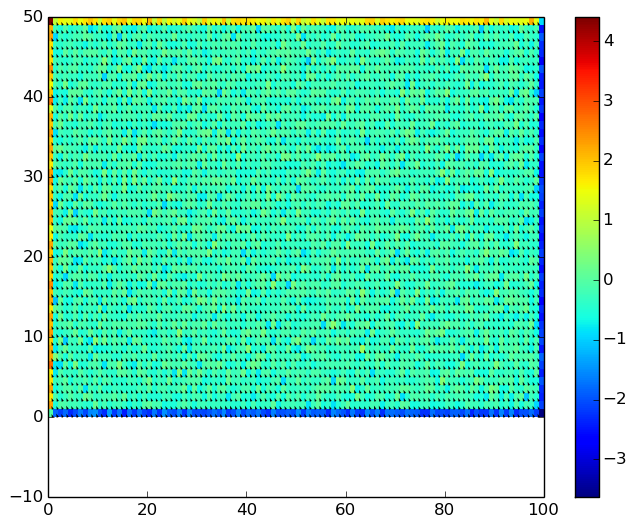

In [38]:
pcolor(η); colorbar(); quiver(uu[1:M,:], vv[:,1:N])
# Alternatively, we can use interpolation for the color plot to appear smoother
# imshow(η); colorbar();

In [39]:
# The time step can be calculated with CFL criterion
for i = 1:10
    Δt = minimum(CFL * Δx ./ (sqrt(g*h) + uu[1:end-1,:]))
    println(Δt)
    # the remaining part of code is similar 
end

3.501799561511091
3.501799561511091
3.501799561511091
3.501799561511091
3.501799561511091
3.501799561511091
3.501799561511091
3.501799561511091
3.501799561511091
3.501799561511091


### Inclusion of motion due to water surface slope

Gravity acceleration due to water surface slope is very important in shallow flows and must be accounted in computation. For that reason we extend the code by including terms like `Δηx` and `Δηy` as gradients of the water surface elevation. 

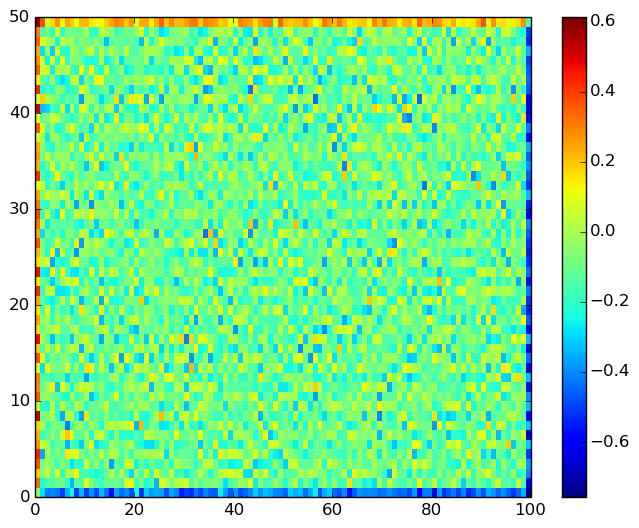

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fe32f7ff5f0>

In [44]:
# assume that we know u, v

uu = -0.5 + 0.1*rand(M+1,N) 
vv = 1.0 + 0.2*rand(M,N+1) 

# CONSIDER to use a meaningful representation of water surface elevation
η = zeros(M,N) - 0.2*rand(M,N)

uu1 = zeros(M+1,N)
vv1 = zeros(M,N+1)

Δηx = zeros(M,N)
Δηy = zeros(M,N)

hu = zeros(M+1,N)
hv = zeros(M,N+1)

for i = 1:1
    
    Δηx[1:end-1,:] = (η[2:end,:] - η[1:end-1,:])/Δx
    Δηy[:,1:end-1] = (η[:,2:end] - η[:,1:end-1])/Δy
    
    h = η - zb

    hu[2:end-1,:] = 0.5(h[1:end-1,:] + h[2:end,:])
    hv[:,2:end-1] = 0.5(h[:,1:end-1] + h[:,2:end])

    # Solve the momentum equation 
    uu1[1:end-1,:] = uu[1:end-1,:] - Δt * (0 - g * Δηx)
    vv1[:,1:end-1] = vv[:,1:end-1] - Δt * (0 - g * Δηy)
    
    # volume fluxes in x and y directions
    qx = uu1 .* hu
    qy = vv1 .* hv

    # Solve the continuity equation 
    η1 = η - Δt * (-(qx[2:end,:] - qx[1:end-1,:])/Δx - (qy[:,2:end] - qy[:,1:end-1])/Δy )
    η = η1
end

pcolor(η1); colorbar();

It is apparent that the water surface is very rough: after several time steps the lowest point on water surface barely reaches the bottom. So we must be very careful and use good techniques to avoid oscillation in simulation. The following technique is employed in [XBeach model](http://oss.deltares.nl/web/xbeach/) accounting for upwind discretization; that means a modification of `hu` and `hv` should be made.

In [ ]:
# assume that we know u, v

uu = -0.5 + 0.1*rand(M+1,N) 
vv = 1.0 + 0.2*rand(M,N+1) 

# CONSIDER to use a meaningful representation of water surface elevation
η = zeros(M,N) - 0.2*rand(M,N)

uu1 = zeros(M+1,N)
vv1 = zeros(M,N+1)

Δηx = zeros(M,N)
Δηy = zeros(M,N)

hu = zeros(M+1,N)
hv = zeros(M,N+1)

for i = 1:1
    
    Δηx[1:end-1,:] = (η[2:end,:] - η[1:end-1,:])/Δx
    Δηy[:,1:end-1] = (η[:,2:end] - η[:,1:end-1])/Δy
    
    h = η - zb

    hu[2:end-1,:] = 0.5(h[1:end-1,:] + h[2:end,:])
    hv[:,2:end-1] = 0.5(h[:,1:end-1] + h[:,2:end])

    # Solve the momentum equation 
    uu1[1:end-1,:] = uu[1:end-1,:] - Δt * (0 - g * Δηx)
    vv1[:,1:end-1] = vv[:,1:end-1] - Δt * (0 - g * Δηy)
    
    # volume fluxes in x and y directions
    qx = uu1 .* hu
    qy = vv1 .* hv

    # Solve the continuity equation 
    η1 = η - Δt * (-(qx[2:end,:] - qx[1:end-1,:])/Δx - (qy[:,2:end] - qy[:,1:end-1])/Δy )
    η = η1
end

pcolor(η1); colorbar();